# imports and config

In [1]:
!pip install nbformat>=4.2.0 entrypoints toolz

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import pandas as pd
import numpy as np
import os

import datetime 
import logging

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from utils import filter_by_rule

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s [%(levelname)s] %(message)s", 
                    datefmt="%d-%b-%y %H:%M:%S")

DATASET = "gaussian_df.csv"
PATH = os.path.join(os.getcwd(), "..", "data", DATASET)
LOWER_CONFIDENCE_BY_PROPORTION = True
OUTLIER_THRESHOLD_NUM_STD = 2

# Loading data

In [3]:

df = pd.read_csv(PATH)
df.head()

,x,y,labels
0,1.614580,-0.100420,0.0
1,1.019888,0.312567,0.0
2,1.493949,0.417392,0.0
3,0.985614,0.118068,0.0
4,0.684116,0.219825,0.0


In [4]:
data = df[["x", "y"]]
n_clusters = 2

In [5]:
# scatter plot
# fig = px.scatter(df, x="x", y="y", color="labels")
# fig.show()

# KMeans

In [6]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")

clustering_labels = kmeans.fit_predict(data)
# # Calculate metrics
# kmeans_silhouette = (silhouette_score(data, clustering_labels)
#                      if len(set(clustering_labels)) > 2 else 0)


Exception in thread Thread-8 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hayk_\.conda\envs\thesis\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\hayk_\.conda\envs\thesis\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\hayk_\.conda\envs\thesis\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\hayk_\.conda\envs\thesis\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number o

In [7]:
kmeans.cluster_centers_

array([[1.19285911, 0.18145612],
       [0.1777886 , 0.90350888]])

In [8]:
from utils import get_distance, remove_outliers_and_normalize
import matplotlib.pyplot as plt

df["distance"] = get_distance(data.values, kmeans)

df["distance_norm"] = remove_outliers_and_normalize(df) 
df.isna().sum().sum()

0

In [9]:
df["distance_norm"].max()

1.01

### KMEANS OPACITY

29-Apr-24 13:24:18 [DEBUG] locator: <matplotlib.ticker.AutoLocator object at 0x0000027F2124FA00>


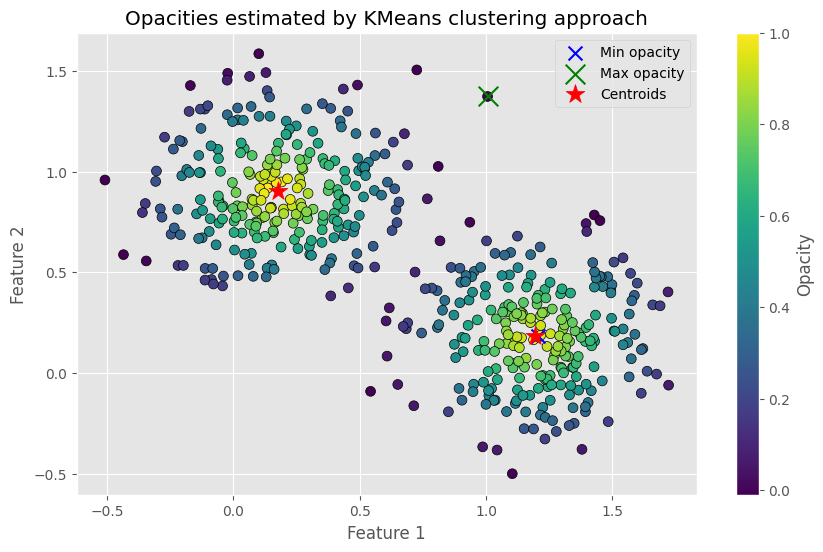

In [35]:
point_min = df[df["distance_norm"] == df["distance_norm"].min()].iloc[0]
point_min = pd.DataFrame(point_min).T
point_max = df[df["distance_norm"] == df["distance_norm"].max()].iloc[8]
point_max = pd.DataFrame(point_max).T
# Plotting
plt.figure(figsize=(10, 6))
X = df.values
plt.style.use('ggplot')
scatter = plt.scatter(X[:, 0], X[:, 1], c=1 - df["distance_norm"].values, cmap='viridis', edgecolor='k', s=50)

plt.colorbar(scatter, label='Opacity')
plt.title('Opacities estimated by KMeans clustering approach')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# print("ok 2")
plt.scatter(point_min[point_min.columns[0]], point_min[point_min.columns[1]], c='blue', s=100, marker='x', label='Min opacity')
plt.scatter(point_max[point_max.columns[0]], point_max[point_max.columns[1]], c='green', s=200, marker='x', label='Max opacity')
# print("ok 3")


# add center of the cluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='*', label='Centroids')
plt.legend()

# save high res
plt.savefig(f"paper/kmeans_opactiy.png", dpi=1000)
# plt.savefig(f"paper/kmeans_opactiy.png")

# plot circle if radius 2 around the point
# circle_min = plt.Circle((point_min[point_min.columns[0]], point_min[point_min.columns[1]]), radius, color='red', fill=False)
# circle_max = plt.Circle((point_max[point_max.columns[0]], point_max[point_max.columns[1]]), radius, color='blue', fill=False)
# plt.gca().add_artist(circle_min)
# plt.gca().add_artist(circle_max)
plt.show()

### DSBCAN OPACITY

In [4]:
from utils import get_distance, remove_outliers_and_normalize, run_dbscan
import matplotlib.pyplot as plt

In [5]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=42, noise=0.1)

df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df["labels"] = y
db = run_dbscan(df, eps=0.01, min_samples=2*X.shape[1])
db

Found the desired number of clusters: 2 at eps=0.08


DBSCAN(eps=0.08, min_samples=4)

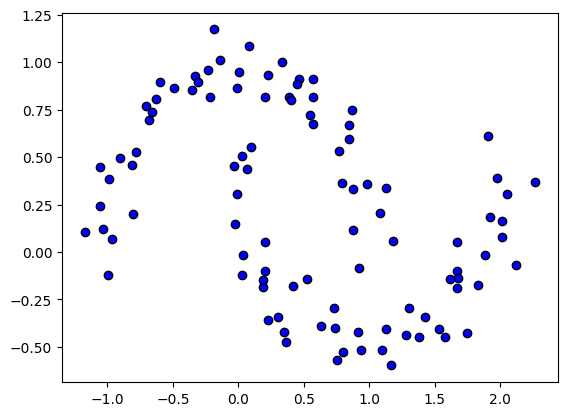

In [7]:
plt.plot(df['Feature 1'], df['Feature 2'], 'o', markerfacecolor='b', markeredgecolor='k', markersize=6)

In [8]:
radius = db.eps * 2

df["distance"] = get_distance(df.values, db, alg="dbscan", density_radius=radius, penalty_rate=0)

df["distance_norm"] = remove_outliers_and_normalize(df) 
df.isna().sum().sum()


0

In [9]:
df[df["distance_norm"] == df["distance_norm"].max()]

,Feature 1,Feature 2,labels,distance,outlier,distance_norm
25,0.462490,0.911661,0,6.0,True,1.01
38,-0.628030,0.803525,0,5.0,True,1.01
49,0.569530,0.814402,0,5.0,True,1.01
94,0.450905,0.884744,0,5.0,True,1.01


In [10]:
df[df["distance_norm"] == df["distance_norm"].min()].iloc[0]


Feature 1       -0.802162
Feature 2        0.202718
labels                  0
distance              0.0
outlier             False
distance_norm         0.0
Name: 4, dtype: object

29-Apr-24 13:54:08 [DEBUG] locator: <matplotlib.ticker.AutoLocator object at 0x000001B285871990>
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\matplotlib\transforms.py:2038: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] += tx
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\matplotlib\transforms.py:2039: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[1, 2] += ty


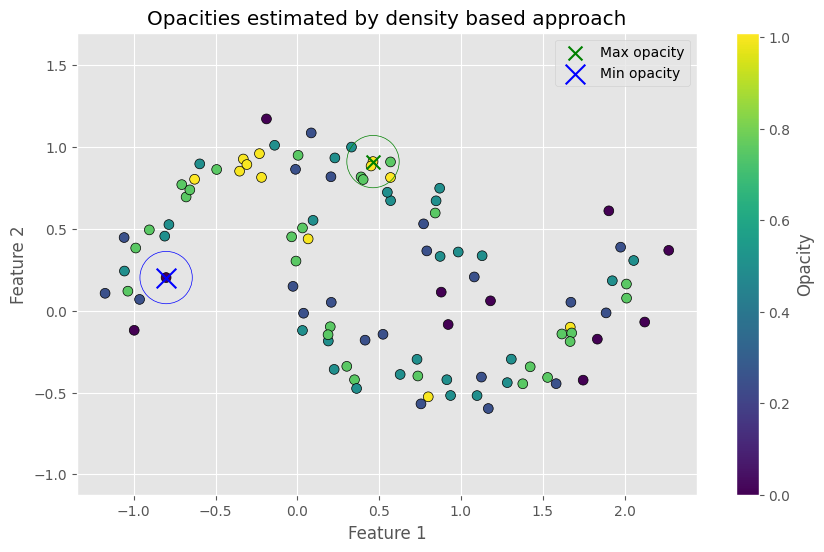

In [16]:
col = "distance_norm"
point_min = df[df[col] == df[col].max()].iloc[0]
point_min = pd.DataFrame(point_min).T
point_max = df[df[col] == df[col].min()].iloc[0]
point_max = pd.DataFrame(point_max).T
# Plotting
plt.figure(figsize=(10, 6))
X = df.values
plt.style.use('ggplot')
scatter = plt.scatter(X[:, 0], X[:, 1], c=df[col].values, cmap='viridis', edgecolor='k', s=50)

plt.colorbar(scatter, label='Opacity')
plt.title('Opacities estimated by density based approach')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# print("ok 2")
plt.scatter(point_min[point_min.columns[0]], point_min[point_min.columns[1]], c='green', s=100, marker='x', label='Max opacity')
plt.scatter(point_max[point_max.columns[0]], point_max[point_max.columns[1]], c='blue', s=200, marker='x', label='Min opacity')
# print("ok 3")
# make the scale uniform
plt.axis('equal')

# add center of the cluster
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='*', label='Centroids')
plt.legend()

# save high res
# plt.savefig(f"paper/kmeans_opactiy.png")

# plot circle if radius 2 around the point
circle_min = plt.Circle((point_min[point_min.columns[0]], point_min[point_min.columns[1]]), radius, color='green', fill=False)
circle_max = plt.Circle((point_max[point_max.columns[0]], point_max[point_max.columns[1]]), radius, color='blue', fill=False)
plt.gca().add_artist(circle_min)
plt.gca().add_artist(circle_max)
plt.savefig(f"paper/denisty_opactiy.png", dpi=1000)

plt.show()

In [7]:
# calculate each points distance to the centroids
df["distance"] = np.min(
    np.linalg.norm(data.values[:, np.newaxis] - kmeans.cluster_centers_, axis=2), axis=1)



In [8]:
df["distance"].isna().sum()

0

In [9]:
# plot
df["labels_clustering"] = clustering_labels.astype(str)


fig = px.scatter(df, x="x", y="y", color="labels_clustering", hover_data=["distance"])

def add_centroids(fig, kmeans):
    fig.add_scatter(x=kmeans.cluster_centers_[:, 0],
                    y=kmeans.cluster_centers_[:, 1],
                    mode="markers",
                    marker=dict(symbol="x", size=15, color="Green"))

    return fig

fig = add_centroids(fig, kmeans)

fig.show()

In [ ]:
df.groupby("labels_clustering").agg({"distance": "max"})

,distance
labels_clustering,
0,0.704649
1,0.951743


# Outliers

In [10]:
def detect_outliers_z_score(data, threshold=OUTLIER_THRESHOLD_NUM_STD):
    outliers = []
    mean = np.mean(data)
    std_dev = np.std(data)
    
    for i in data:
        z_score = (i - mean) / std_dev 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

outliers = detect_outliers_z_score(df["distance"])

df["outlier"] = df["distance"].apply(lambda x: x in outliers)


In [9]:
# def get_distance(df, model, alg="kmeans"):#, remove_outliers=True, normalize=True):
#     if alg == "kmeans":
#         distances = np.min(
#             np.linalg.norm(df[:, np.newaxis] - model.cluster_centers_, axis=2), axis=1) 
#     else:
#         raise NotImplementedError("Only KMeans is supported")    
    
#     return distances

# def remove_outliers_and_normalize(df, distance_column="distance", label_column="labels"):
#     outliers = detect_outliers_z_score(df["distance"])
#     df["outlier"] = df[distance_column].apply(lambda x: x in outliers)
#     df_no_outliers = df[~df["outlier"]]
    
#     # min max scale the df. dont use outliers
#     min_val = df_no_outliers.groupby(label_column)[distance_column].apply('min')
#     max_val = df_no_outliers.groupby(label_column)[distance_column].apply('max')
    
#     def scale(x, label):
#         return (x - min_val[label]) / (max_val[label] - min_val[label]) if max_val[label] > min_val[label] else 0
        
#     dist_norm = df.apply(lambda row: scale(row[distance_column], row[label_column]), axis=1)
    
#     return dist_norm



InvalidIndexError: (slice(None, None, None), None)

In [11]:
# plota
fig = px.scatter(df, x="x", y="y", color="labels_clustering", symbol="outlier", symbol_map={True: "cross", False: "circle"})

# add crosses for centroids
fig.add_scatter(x=kmeans.cluster_centers_[:, 0],
                y=kmeans.cluster_centers_[:, 1],
                mode="markers",
                marker=dict(symbol="x", size=15, color="Green"))

fig.show()

In [12]:
df_okay = df[~df["outlier"]]

# normalize distance to centroid for each cluster
df["distance_norm"] = df_okay.groupby("labels_clustering")["distance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()))

df

,x,y,labels,distance,labels_clustering,outlier,distance_norm
0,1.614580,-0.100420,0.0,0.507250,0,False,0.810779
1,1.019888,0.312567,0.0,0.217046,0,False,0.333554
2,1.493949,0.417392,0.0,0.382519,0,False,0.605665
3,0.985614,0.118068,0.0,0.216723,0,False,0.333022
4,0.684116,0.219825,0.0,0.510188,0,False,0.815609
...,...,...,...,...,...,...,...
495,0.427324,1.220816,1.0,0.403673,1,False,0.616120
496,-0.237872,1.111249,1.0,0.464682,1,False,0.720242
497,0.109251,0.857175,1.0,0.082730,1,False,0.068382
498,0.039282,1.253865,1.0,0.376740,1,False,0.570155


In [32]:
df[df["distance_norm"] > 1]

,x,y,labels,distance,labels_clustering,outlier,distance_norm
11,1.428571,0.784181,0.0,0.647177,0,True,1.040881
89,1.103929,-0.499643,0.0,0.686880,0,True,1.106171
172,1.451091,0.756414,0.0,0.630286,0,True,1.013105
238,0.542905,-0.090739,0.0,0.704649,0,True,1.135391
310,0.810649,1.025334,1.0,0.644480,1,True,1.027094
382,0.725845,1.504217,1.0,0.813152,1,True,1.314958
386,-0.435476,0.587533,1.0,0.689880,1,True,1.104576
392,0.100315,1.584489,1.0,0.685373,1,True,1.096884
467,1.005983,1.372453,1.0,0.951743,1,True,1.551485
485,-0.508764,0.957781,1.0,0.688694,1,True,1.102552


In [28]:
import plotly.io as pio

# Set the template to "ggplot"
pio.templates.default = "ggplot2"

# Your existing code for creating the scatter plot
fig = px.scatter(df, x="x", y="y", color="distance_norm")

# Add the centroids
fig.add_scatter(x=kmeans.cluster_centers_[:, 0],
                y=kmeans.cluster_centers_[:, 1],
                mode="markers",
                marker=dict(symbol="x", size=15, color="Green"))

# Show the plot
fig.show()

# Rule scoring

In [4]:
# def filter_by_rule(df, rule_lambda, lower_confidence_by_proportion=LOWER_CONFIDENCE_BY_PROPORTION,
#                    only_plot=False):
#     """
#     Filters a DataFrame based on a given rule lambda function and calculates the confidence score.

#     Note:
#         The confidence score is calculated as the average distance to the centroid of the most common cluster.
#         If the data points belong to the same cluster, the confidence score is the average distance to the centroid.
#         If the data points belong to different clusters, the confidence score is the average distance to the centroid of the most common cluster.
#         If the confidence score is lowered by proportion, the confidence score is multiplied by the proportion of data points in the most common cluster.

#         Since the closer the data points are to the centroid, the better, the confidence score is calculated as 1 - ... 
#     Args:
#         df (pd.DataFrame): The input DataFrame to filter.
#         rule_lambda (function): A lambda function that defines the filtering rule.
#         lower_confidence_by_proportion (bool, optional): Whether to lower the confidence score by proportion. 
#             Defaults to True.
#         only_plot (bool, optional): Whether to to only plot the data. Defaults to False.
        
#     Returns:
#         tuple: A tuple containing the filtered DataFrame and the confidence score.

#     Example:
#         filter_by_rule(df, lambda row: row["x"]>0.5 and row["y"]>0.5)
        

#     """
    
#     # example is lambda row: row["x"]>0.5 and row["y"]>0.5
#     df["rule_applies"] = df.apply(rule_lambda, axis=1)
    
#     df_rule = df[df["rule_applies"]]
    
#     if df_rule.empty:
#         logging.info("No data points left after filtering")
#         return df
    
#     if only_plot:
#         fig = px.scatter(df, x="x", y="y", color="rule_applies")
#         fig = add_centroids(fig, kmeans)
#         fig.show()
#         return fig 
    
#     num_labels = df_rule["labels_clustering"].nunique()
    
#     logging.info(f"Number of data points left after filtering: {len(df_rule)}")
#     logging.info(f"Number of clusters left after filtering: {num_labels}")  
    
#     if df_rule["labels_clustering"].nunique() == 1:
#         logging.info("All data points belong to the same cluster")
#         confidence = df_rule["distance_norm"].mean()
        
#         logging.info(f"Confidence: {confidence}")
#     else:
#         logging.info("Data points belong to different clusters")
#         # most common cluster
#         most_common_cluster = df_rule["labels_clustering"].mode().values[0]
#         logging.info(f"Most common cluster: {most_common_cluster}")
        
#         # confidence
#         confidence = df_rule[df_rule["labels_clustering"] == most_common_cluster]["distance_norm"].mean()
#         logging.info(f"Confidence: {confidence}")
        
#         if lower_confidence_by_proportion:
#             # num of data points in most common cluster
#             num_points = len(df_rule[df_rule["labels_clustering"] == most_common_cluster])
#             # proportion of data points in most common cluster
#             proportion = num_points / len(df_rule)
            
#             confidence = confidence * proportion
#             logging.info(f"Confidence after lowering based on proportion: {confidence}")
            
#     return df, 1 - confidence


In [5]:
d, conf = filter_by_rule(df_okay, lambda row: 0.2<row["x"]<0.3 and 0.5<row["y"]<1)

fig = px.scatter(d, x="x", y="y", color="rule_applies")

fig = add_centroids(fig, kmeans)

fig

NameError: name 'df_okay' is not defined

In [ ]:
d, conf = filter_by_rule(df_okay, lambda row: 0.5<row["x"]<1 and 0.5<row["y"]<1)

fig = px.scatter(d, x="x", y="y", color="rule_applies")

fig = add_centroids(fig, kmeans)

fig

C:\Users\hayk_\AppData\Local\Temp\ipykernel_15296\2841469021.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

23-Apr-24 19:30:00 [INFO] Number of data points left after filtering: 20
23-Apr-24 19:30:00 [INFO] Number of clusters left after filtering: 2
23-Apr-24 19:30:00 [INFO] Data points belong to different clusters
23-Apr-24 19:30:00 [INFO] Most common cluster: 1
23-Apr-24 19:30:00 [INFO] Confidence: 0.7030490123603427
23-Apr-24 19:30:00 [INFO] Confidence after lowering based on proportion: 0.45698185803422275


# Rules generators

## CN2

https://github.com/scikit-learn-contrib/skope-rules/issues/58

https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals

In [19]:
# !pip install skope-rules

In [20]:
# df_use = df[["x", "y", "labels_clustering"]]

In [21]:
# import six
# import sys
# sys.modules['sklearn.externals.six'] = six

# from sklearn.datasets import load_iris
# from skrules import SkopeRules

# feature_names = df_use.columns
# clf = SkopeRules(max_depth_duplication=3,
#                  n_estimators=30,
#                  precision_min=0.02,
#                  recall_min=0.02,
#                  feature_names=feature_names)

# # for idx, species in enumerate(df_use):
# #     print(idx, species)
# X, y = df_use[["x", 'y']], df_use["labels_clustering"].astype(int )

# clf.fit(X, y)
# rules = clf.rules_[0:3]
# # print("Rules for iris", species)
# for rule in rules:
#     print(rule)
# print()
# print(20*'=')
# print()

In [22]:
# import Orange

# # Sample data: a mix of categorical and numerical features
# data = Orange.data.Table(PATH)  # using an in-built dataset for demonstration

# # Initialize the CN2 learner
# learner = Orange.classification.rules.CN2Learner()

# # Fit the model
# classifier = learner(data)


# import Orange

# data = Orange.data.Table("iris")
# learner = Orange.classification.CN2UnorderedLearner()

# # # consider up to 10 solution streams at one times
# # learner.rule_finder.search_algorithm.beam_width = 10

# # # continuous value space is constrained to reduce computation time
# # learner.rule_finder.search_strategy.constrain_continuous = True

# # # found rules must cover at least 15 examples
# # learner.rule_finder.general_validator.min_covered_examples = 15

# # # found rules may combine at most 2 selectors (conditions)
# learner.rule_finder.general_validator.max_rule_length = 2

# classifier = learner(data)

# print(classifier.rule_list[0])

# # Output rules
# print("Rules generated from CN2 algorithm:")

# print(classifier.rule_list[0])
# # for rule in classifier.rule_list:
# #     print(Orange.classification.rules.to_string(rule))

# DS

In [6]:
!pip install tqdm

  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)


In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import pandas as pd
import numpy as np
import json
import os

import datetime 
import logging

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils import filter_by_rule


from DSClassifierMultiQ import DSClassifierMultiQ
from DSRule import DSRule

from tqdm import tqdm

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))


logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s", 
                    datefmt="%d-%b-%y %H:%M:%S")

# DATASET = "gaussian_df.csv"
# PATH = os.path.join(os.getcwd(), "..", "data", DATASET)
LOWER_CONFIDENCE_BY_PROPORTION = True
OUTLIER_THRESHOLD_NUM_STD = 2

DATA_FOLDER = os.path.join(os.getcwd(), "..", "data_binary_scaled")
num_breaks = 3


assert os.path.exists(DATA_FOLDER), f"Data folder {DATA_FOLDER} does not exist"

datasets = [i for i in os.listdir(DATA_FOLDER) if i.endswith("csv")]

def report_results(y_test, y_pred, epoch=None, dt=None, losses=None, method=None, dataset=None, 
                   name=None, save_results=False, save_path=None, print_results=True):
    if epoch and dt and losses:
        if print_results:
            logging.info(f"Training Time: {dt:.2f}s")
            logging.info(f"Epochs: {epoch+1}")
            logging.info(f"Min Loss: {losses[-1]:.3f}")
            px.line(losses, markers=True).show()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if print_results:
        logging.info(f"Accuracy:  {accuracy:.2f}")
        logging.info(f"F1 Score: {f1:.2f}")
        logging.info(f"Confusion Matrix: \n{conf_matrix}")
    
    if save_results:
        now = datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")
        if save_path is None:
            save_path = f"experiments.csv"
        if name is None:
            name = "No name"
        res_row = {"name": name, "MAF method": method, "dataset": dataset,
                   "accuracy": accuracy, "f1": f1, 
                    "confusion_matrix": conf_matrix, 
                    "training_time": dt, "epochs": epoch+1,"min_loss": losses[-1], 
                    "datetime": now, }
        
        res_df = pd.read_csv(save_path) if os.path.exists(save_path) else pd.DataFrame()
        res_df = pd.concat([res_df, pd.DataFrame([res_row])], ignore_index=True)
        res_df.to_csv(save_path, index=False)
        
        
# df_okay.to_csv("df_okay.csv", index=False)
for path in tqdm(datasets):
    logging.info(f"\n ------ Processing {path} ------")
    
    dataset_name = path.split(".")[0]
    
    data = pd.read_csv(os.path.join(DATA_FOLDER, path))
    
    if "id" in data.columns:
        data = data.drop("id", axis=1)
    
    #? perhaps wont need this
    data = data.drop("labels", axis=1)
    
    ignore_for_training = ["labels_clustering", "distance_norm"]
    df_cols = [i for i in list(data.columns) if i not in ignore_for_training]
    
    assert "distance_norm" in data.columns, "Must have 'distance_norm' column"
    assert data.columns[-1] == "labels_clustering", "Last column must be 'labels_clustering'"
    print(data["labels_clustering"].value_counts())
    logging.info(f"Step 0: Data read done")
    
    data = data.sample(frac=1).reset_index(drop=True)
    data = data.apply(pd.to_numeric)
    cut = int(0.7*len(data))

    train_data_all = data.iloc[:cut]
    
    X_train_all = data.iloc[:cut, :-1]#.values
    y_train = data.iloc[:cut, -1].values
    X_test_all = data.iloc[cut:, :-1]#.values
    y_test = data.iloc[cut:, -1].values
        
    X_train = X_train_all.drop("distance_norm", axis=1).values
    
    X_test = X_test_all.drop("distance_norm", axis=1).values
    logging.info(f"Step 1: Data split done")
    logging.debug(f"\tTrain: {len(X_train_all)} Test: {len(X_test_all)}")

    for method in ["random", "kmeans"]:
        name = f"{path} (scaled), {num_breaks} single breaks, add_mult_rules, maf_method={method}"
        logging.debug(f"\tSTART {name}")
        DSC = DSClassifierMultiQ(2, debug_mode=True, num_workers=0, maf_method=method,
                                data=train_data_all) 

        # assert X and y train are numpy arrays
        assert isinstance(X_train, np.ndarray), "X_train must be a numpy array"
        assert isinstance(y_train, np.ndarray), "y_train must be a numpy array"
        logging.info(f"Step 2: Model init done")
        res = DSC.fit(X_train, y_train, 
                    add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=True,
                    column_names=df_cols, print_every_epochs=5, print_final_model=True)
        losses, epoch, dt = res

        logging.info(f"Step 3: Model fit done")

        DSC.model.save_rules_bin(os.path.join("rules_saved", f"{name}.dsb"))

        # dataset_name.lstrip("K")
        with open(os.path.join(DATA_FOLDER, "results", f"{dataset_name}.json")) as f:
            results = json.load(f)

        logging.info(f"Step 4: Model save done")
        
        st_sc = StandardScaler()
        st_sc.scale_ = np.array(results["scale"])
        st_sc.mean_ = np.array(results["mean"])
        st_sc.var_ = np.array(results["var"])
        
        X_test = st_sc.transform(X_test)
        
        y_pred = DSC.predict(X_test)
        
        logging.info(f"Step 5: Inference done")
        
        report_results(y_test, y_pred, dataset=dataset_name, method=method,
                       epoch=epoch, dt=dt, losses=losses, 
                    save_results=True, name=name, print_results=False)
        logging.info("-"*30)
    break

  0%|          | 0/5 [00:00<?, ?it/s]26-Apr-24 14:42:47 [INFO] 
 ------ Processing kmeans_breast-cancer-wisconsin.csv ------
26-Apr-24 14:42:47 [INFO] Step 0: Data read done
26-Apr-24 14:42:47 [INFO] Step 1: Data split done
26-Apr-24 14:42:47 [INFO] Step 2: Model init done


labels_clustering
1    455
0    228
Name: count, dtype: int64
Optimization started
Processing epoch	96	0.0162	

26-Apr-24 14:43:13 [INFO] Step 3: Model fit done
26-Apr-24 14:43:13 [INFO] Step 4: Model save done
26-Apr-24 14:43:13 [INFO] Step 5: Inference done
26-Apr-24 14:43:13 [INFO] ------------------------------
26-Apr-24 14:43:13 [INFO] Step 2: Model init done



Training time: 25.99s, epochs: 97

Least training loss reached: 0.016
DSModelMultiQ(
  DS Classifier using 108 rules
  
  Rule 1: clump_thickness < -0.685
  	C1: 0.000	C2: 0.219	Unc: 0.781
  
  Rule 2: -0.685 < clump_thickness < -0.014
  	C1: 0.000	C2: 0.239	Unc: 0.761
  
  Rule 3: -0.014 < clump_thickness < 0.656
  	C1: 0.231	C2: 0.000	Unc: 0.769
  
  Rule 4: clump_thickness > 0.656
  	C1: 0.292	C2: 0.000	Unc: 0.708
  
  Rule 5: size_uniformity < -0.655
  	C1: 0.000	C2: 0.268	Unc: 0.732
  
  Rule 6: -0.655 < size_uniformity < 0.030
  	C1: 0.000	C2: 0.295	Unc: 0.705
  
  Rule 7: 0.030 < size_uniformity < 0.715
  	C1: 0.278	C2: 0.000	Unc: 0.722
  
  Rule 8: size_uniformity > 0.715
  	C1: 0.272	C2: 0.000	Unc: 0.728
  
  Rule 9: shape_uniformity < -0.662
  	C1: 0.000	C2: 0.262	Unc: 0.738
  
  Rule 10: -0.662 < shape_uniformity < 0.011
  	C1: 0.005	C2: 0.211	Unc: 0.784
  
  Rule 11: 0.011 < shape_uniformity < 0.683
  	C1: 0.193	C2: 0.005	Unc: 0.802
  
  Rule 12: shape_uniformity > 0.683
 

26-Apr-24 14:43:17 [INFO] Step 3: Model fit done
26-Apr-24 14:43:17 [INFO] Step 4: Model save done
26-Apr-24 14:43:17 [INFO] Step 5: Inference done
26-Apr-24 14:43:17 [INFO] ------------------------------
  0%|          | 0/5 [00:30<?, ?it/s]


Training time: 3.59s, epochs: 13

Least training loss reached: 0.019
DSModelMultiQ(
  DS Classifier using 108 rules
  
  Rule 1: clump_thickness < -0.685
  	C1: 0.122	C2: 0.755	Unc: 0.123
  
  Rule 2: -0.685 < clump_thickness < -0.014
  	C1: 0.106	C2: 0.789	Unc: 0.106
  
  Rule 3: -0.014 < clump_thickness < 0.656
  	C1: 0.125	C2: 0.750	Unc: 0.125
  
  Rule 4: clump_thickness > 0.656
  	C1: 0.526	C2: 0.210	Unc: 0.264
  
  Rule 5: size_uniformity < -0.655
  	C1: 0.124	C2: 0.751	Unc: 0.125
  
  Rule 6: -0.655 < size_uniformity < 0.030
  	C1: 0.173	C2: 0.654	Unc: 0.173
  
  Rule 7: 0.030 < size_uniformity < 0.715
  	C1: 0.574	C2: 0.187	Unc: 0.239
  
  Rule 8: size_uniformity > 0.715
  	C1: 0.511	C2: 0.217	Unc: 0.272
  
  Rule 9: shape_uniformity < -0.662
  	C1: 0.030	C2: 0.889	Unc: 0.081
  
  Rule 10: -0.662 < shape_uniformity < 0.011
  	C1: 0.160	C2: 0.680	Unc: 0.160
  
  Rule 11: 0.011 < shape_uniformity < 0.683
  	C1: 0.602	C2: 0.172	Unc: 0.226
  
  Rule 12: shape_uniformity > 0.683
  

## Data prep

In [3]:
# df_okay.to_csv("df_okay.csv", index=False)

df_okay = pd.read_csv("df_okay.csv")

In [4]:
# train test split

X = df_okay[["x", "y"]]
y = df_okay["labels_clustering"]

data = df_okay[["x", 'y', 'labels_clustering']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
data = data.sample(frac=1).reset_index(drop=True)

data = data.apply(pd.to_numeric)
cut = int(0.7*len(data))

X_train = data.iloc[:cut, :-1].values
y_train = data.iloc[:cut, -1].values
X_test = data.iloc[cut:, :-1].values
y_test = data.iloc[cut:, -1].values


logging.info(f"Train: {len(X_train)} Test: {len(X_test)}")



23-Apr-24 21:20:45 [INFO] Train: 343 Test: 147


In [9]:

# data = pd.read_csv("../data/breast-cancer-wisconsin.csv")

# data = data.drop("id", axis=1)
# data["class"] = data["class"].map({2: 0, 4: 1})

# data = data.apply(pd.to_numeric, args=("coerce",))
# data = data.sample(frac=1).reset_index(drop=True)

# cut = int(0.7*len(data))

# X_train = data.iloc[:cut, :-1].values
# y_train = data.iloc[:cut, -1].values
# X_test = data.iloc[cut:, :-1].values
# y_test = data.iloc[cut:, -1].values


In [7]:
# def uniform_rule(X, num_parts=5, col_names=None):
#     # create a uniform rule
#     rules = []
    
#     for i in range(X.shape[1]):
#         col = X[:, i]
#         min_val = np.min(col)
#         max_val = np.max(col)
        
#         step = (max_val - min_val) / num_parts
        
#         for j in range(num_parts):
#             text = f"{min_val + j*step} <= x[{i}] <= {min_val + (j+1)*step}"
#             print(text)
#             # todo
#             rules.append(DSRule(lambda x: min_val + j*step <= x[i] <= min_val + (j+1)*step))
            
#     return rules

In [8]:
# rules = uniform_rule(X_train, 3, col_names=["x", "y"])
# rules

## Run Model

In [12]:


# from importlib import reload
# reload(DSClassifierMultiQ)


In [5]:

from DSClassifierMultiQ import DSClassifierMultiQ
from DSRule import DSRule

num_breaks = 3
method = "full"
method = "kmeans"
name = f"gauusian, {num_breaks} single breaks, add_mult_rules=False,  maf_method={method}"


logging.info("Training DSClassifierMultiQ")
# DSC = DSClassifierMultiQ(2, debug_mode=True, num_workers=0)
DSC = DSClassifierMultiQ(2, debug_mode=True, num_workers=0, maf_method=method,
                         data=df_okay.iloc[:cut])

DSC.model.add_rule(DSRule(lambda x: x[0] > 18, "Patient is adult"))
# DSC.model.add_rule(DSRule(lambda x: x[0] < 18, "Patient is adult"))
# for i in range(len(rules)):
#     # print(rules[i])
#     DSC.model.add_rule(rules[i])


# for num_breaks in [2, 3, 4, 5]:


res = DSC.fit(X_train, y_train, 
            add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=False,
            column_names=["x", 'y'], print_every_epochs=1, print_final_model=True)

losses, epoch, dt = res

DSC.model.save_rules_bin(os.path.join("rules_saved", f"{name}.dsb"))


y_pred = DSC.predict(X_test)

    
report_results(y_test, y_pred, epoch=epoch, dt=dt, losses=losses, 
            save_results=True, name=name)

23-Apr-24 21:20:49 [INFO] Training DSClassifierMultiQ


Patient is adult pred
[0.08894394 0.11105606 0.8       ]
x < 0.312 pred


AssertionError: Data must be provided for kmeans method

In [ ]:




# print("Explaining instance: ")
# print(X_test[0])
# pred, cls, rls, builder = DSC.predict_explain(X_test[0])
# print(builder)
# print(rls)

23-Apr-24 18:20:16 [INFO] Training Time: 25.26s
23-Apr-24 18:20:16 [INFO] Epochs: 200
23-Apr-24 18:20:16 [INFO] Min Loss: 0.027


23-Apr-24 18:20:16 [INFO] Accuracy:  0.98
23-Apr-24 18:20:16 [INFO] F1 Score: 0.98
23-Apr-24 18:20:16 [INFO] Confusion Matrix: 
[[67  2]
 [ 1 77]]


In [ ]:

X_train_df = data.iloc[:cut, :-1].values
y_train = data.iloc[:cut, -1].values
X_test = data.iloc[cut:, :-1].values
y_test = data.iloc[cut:, -1].values

,x,y,labels_clustering
0,1.245085,-0.067630,0
1,0.519859,1.021516,1
2,0.384995,1.313368,1
3,1.233272,0.415007,0
4,1.109102,0.135470,0
...,...,...,...
485,1.233437,0.302323,0
486,1.263470,-0.236248,0
487,1.188081,0.165184,0
488,1.577180,0.358378,0


In [ ]:
DSC.find_most_important_rules(threshold=0.1)

{0: [(0.03163551673105758,
   5,
   '0.234 < y < 0.527',
   0.17786375890286807,
   array([0.15833704, 0.04146155, 0.8002014 ], dtype=float32)),
  (0.028245294758107775,
   4,
   'y < 0.234',
   0.16806336530638608,
   array([0.14274216, 0.05513415, 0.80212367], dtype=float32)),
  (0.024575292036107754,
   1,
   '0.329 < x < 0.708',
   0.15676508551366836,
   array([0.1290192 , 0.06145862, 0.8095222 ], dtype=float32)),
  (0.024048811874058273,
   3,
   'x > 1.086',
   0.1550767934736151,
   array([0.12398298, 0.06998566, 0.80603135], dtype=float32)),
  (0.021501795279943003,
   2,
   '0.708 < x < 1.086',
   0.14663490471215576,
   array([0.11201493, 0.07993972, 0.80804527], dtype=float32)),
  (0.021418596140573953,
   7,
   'y > 0.819',
   0.14635093488110676,
   array([0.11235696, 0.07827288, 0.8093701 ], dtype=float32)),
  (0.012596876743142804,
   6,
   '0.527 < y < 0.819',
   0.11223580864921322,
   array([0.06448371, 0.13086608, 0.80465025], dtype=float32))],
 1: [(0.0405167148707